# Table of Contents
 <p>

All Proposed Models in the Paper (https://arxiv.org/abs/1703.07684v2):

- X2X - Frame X(1:t) to frame X(t+1)

- S2S - Semantic Seg S(1:t) to Semantic Seg S(t+1) 

- XS2X - (X(1:t),S(1:t)) to X(t+1)

- XS2S - (X(1:t),S(1:t)) to S(t+1)

- XS2XS - (X(1:t),S(1:t)) to X(t+1),S(t+1)


Current model X2X (Simplest)

X2X Architecture:

- Multi-Scale model with scales: s_1 and s_2

- Scale Module (A Conv Network)
    - Layers: 4 (alternate between Conv  and ReLU)
    - Output channels: C
    - Feature Maps: 128, 256, 128 (C channels each)

- s_1 Conv Kernal size: 3,3,3,3
- s_2 Conv Kernal size: 5,3,3,5

- Last non linear function: tanh (normalized RGB)

- Output at s_1 is up-sampled and used as input to s_2


In [20]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages')
sys.path.append('/Users/pmishra/anaconda3/lib/python3.5/site-packages ')

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import optimizers

#K.set_image_dim_ordering('tf')

# Constants

C = 1 # Num of Channels
NUM_PREV_FRAMES = 2 # Num of previous inputs fed into the autoregressive model 

INPUT_IMG_HEIGHT = 64
INPUT_IMG_WIDTH = 64

# Helpers

def get_next_scale_factor(scales, scale_id):
    return 1/(2**((scales -1) - scale_id))

In [22]:
import numpy as np
import random

data = np.load('mnist_test_seq.npy')

# data has the shape (20, 10000, 64, 64) where 
# dimension 1: is number of frames (sequences)
# dimension 2: is number of images (total samples)
# dimension 3: is number of img height
# dimension 4: is number of img width

max_img = data.shape[1]

batch_size = 5
input_frames_size = NUM_PREV_FRAMES # num of history of frames to be fed into auto-regression network
target_frames_size = 1
img_h = 64
img_w = 64
max_seq = 20

total_frames = input_frames_size+target_frames_size
input_frames = np.empty([2*batch_size, total_frames, img_h, img_w])

# network input shape(batch_size, img_h, img_w, total_frames)
X_frames = np.empty([2*batch_size, img_h, img_w, total_frames])

# two batch for discriminator and generator packed into one input
for i in range(2*batch_size):
    img_num = random.randint(0, max_img)
    frame_num = random.randint(0, max_seq-5)
    input_frames[i] = data[frame_num:frame_num+total_frames, img_num]
    for j in range(total_frames):
        X_frames[i,:,:,j] = data[frame_num+j, img_num]
    


In [23]:
X_frames[:,:,:,:].shape

(10, 64, 64, 3)

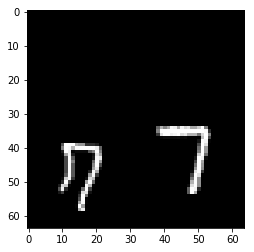

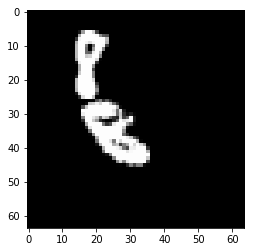

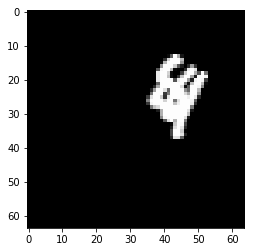

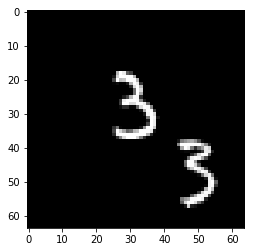

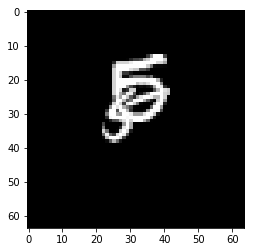

In [24]:
import matplotlib.pyplot as plt

get_ipython().magic('matplotlib inline')

for i in range(batch_size):
    pixels = input_frames[i,NUM_PREV_FRAMES,:,:].reshape(64,64) #images[i][10]
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [25]:
#plt.imshow(resize(pixels, [32,32]), cmap='gray')
#plt.show()

In [120]:
class AutoRegressiveModel:
    """
    Use previous trained subnetworks to predict more than one time
    step ahead in time in autoregressive method
    """
    def __init__(self, regression_level, epochs):
        """
        
        Args:
            param1: regression_level - number of levels of recursion 
            param2: epochs
            
            
        """
        self.epochs = epochs
        self.current_step = 0
        self.regression_level = regression_level
        
        num_scale_nets = 2
        
        
        g_scale_fms = [[8, 16, 8, C], [8, 16, 8, C]]
        g_scale_k_sizes = [[3 ,3 ,3 ,3], [5, 3, 3, 5]]
    
            
        self.generator = GeneratorNetwork(INPUT_IMG_HEIGHT, #input height
                                        INPUT_IMG_WIDTH, #input width
                                        num_scale_nets,
                                        g_scale_fms,
                                        g_scale_k_sizes)
        
        
        d_scale_fms = [[8], [8, 8, 16]]
        d_scale_k_sizes = [[3], [5, 5, 5]]
        d_scale_fc_sizes = [[32, 16, 1], [32, 16, 1]]
        
        self.disriminator = DisriminatorNetwork(INPUT_IMG_HEIGHT, #input height
                                                INPUT_IMG_WIDTH, #input width
                                                num_scale_nets,
                                                d_scale_fms,
                                                d_scale_k_sizes,
                                                d_scale_fc_sizes)

        
    def train_ar_model(self, X_frames, batch_size):
        # divide data into two separate batches for each network
        d_input = X_frames[0:batch_size,:,:,0:NUM_PREV_FRAMES]
        d_ground_t_seq = X_frames[0:batch_size,:,:,NUM_PREV_FRAMES:]
        
        g_input = X_frames[batch_size:,:,:,0:NUM_PREV_FRAMES]
        g_ground_t_seq = X_frames[batch_size:,:,:,NUM_PREV_FRAMES:]
        
        for i in range(self.epochs):
            self.disriminator.train(d_input, d_ground_t_seq, self.generator)
            self.generator.train_model(g_input, g_ground_t_seq)
            
    
    def test(self, test_frames, sample_size):
        return self.generator.test_model(test_frames, sample_size)

In [130]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

class GeneratorNetwork:
    def __init__(self, input_height, input_width, num_scale_modules, 
                 scale_modules_fms_sizes, scale_modules_kernel_sizes):
        """
        
        Args:
        
            param1: input_height - image dim1
            param2: input_width - image dim2
            param3: num_scale_modules - subnetworks with distinct scales
            param4: scale_modules_fms_sizes - conv layer feature maps list
            param5: scale_modules_kernel_sizes - kernel size list
            
            
        """
        self.input_height = input_height
        self.input_width = input_width
        assert len(scale_modules_fms_sizes) == num_scale_modules, 'fm sizes list must == num scale models'
        self.scale_modules_fms_sizes = scale_modules_fms_sizes
        assert len(scale_modules_kernel_sizes) == num_scale_modules, 'k sizes list must == num scale models'
        self.scale_modules_kernel_sizes = scale_modules_kernel_sizes
        self.num_scale_modules = num_scale_modules
        
    #def compute(self, input_height, input_width, ground_truth_seq, prev_frames):
        
    
    def build_model(self):
        
        self.scale_modules = []
        
        # Storage for predicted and ground truth sequences
        self.per_scale_output = []
        self.per_scale_ground_truth_seq = []
        self.d_net_outputs = []
        
        #self.per_scale_test = []
        #self.per_scale_ground_truth_seq_test = []

        self.input_frames = K.placeholder(shape=(None, self.input_height, 
                                                 self.input_width,
                                                C * NUM_PREV_FRAMES))
        self.ground_truth_frames = K.placeholder(shape=(None, self.input_height, 
                                                 self.input_width,
                                                C))
        
        self.current_batch_size = self.input_frames[0]
        
        
        for i in range(self.num_scale_modules):
            model = Sequential()
            for j in range(len(self.scale_modules_kernel_sizes[i])):
                if j == 0:
                    model.add(Conv2D(self.scale_modules_fms_sizes[i][j], 
                                  kernel_size=(self.scale_modules_kernel_sizes[i][j], 
                                                self.scale_modules_kernel_sizes[i][j]),
                                  activation='relu', padding='same',
                                  input_shape=(self.input_height, 
                                                 self.input_width,
                                                C * NUM_PREV_FRAMES)))
                elif j == (len(self.scale_modules_kernel_sizes[i])-1):
                    model.add(Conv2D(self.scale_modules_fms_sizes[i][j], 
                                  kernel_size=(self.scale_modules_kernel_sizes[i][j], 
                                                self.scale_modules_kernel_sizes[i][j]),
                                  activation='tanh', padding='same'))     
                else:    
                    model.add(Conv2D(self.scale_modules_fms_sizes[i][j], 
                                  kernel_size=(self.scale_modules_kernel_sizes[i][j], 
                                                self.scale_modules_kernel_sizes[i][j]),
                                  activation='relu', padding='same'))                    
               
            self.scale_modules.append(model)

            
    def compile_model(self):
        for i in range(self.num_scale_modules):
            model = self.scale_modules[i]
            model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
            
    def train_model(self, X_train, Y_train):
        self.latest_predicted_frames = []
        b = batch_size
        for i in range(self.num_scale_modules):
            model = self.scale_modules[i]
            model.fit(X_train, Y_train, batch_size=b, nb_epoch=2, verbose=0)
            self.latest_predicted_frames.append(model.predict(X_train, batch_size=b))
            
            
    def test_model(self, test_frames, batch_size):
        for i in range(self.num_scale_modules):
            model = self.scale_modules[i]
            frames = model.predict(test_frames, batch_size)
        return frames 

In [131]:
class ScaleModule:
    """
    A ScaleModule is a convolutional network on its own. This module is a 
    subnetwork with a pre-specified scale in a larger muti-scale network. No 
    pooling is employed at ScaleModule level. 
    
    The output of the coarser network (lower in scale) is used as an input to
    the next scale module along with a copy of lower scale input.
    
    """
    def __init__(self, scale_id, img_h, img_w, conv_fms_sizes, kernel_sizes, fc_sizes):
        """
        
        Initialize the ScaleModule
        
        Args:
        
            param1: img_h - image dim1
            param2: img_w - image dim2
            param3: conv_fms_sizes - conv layer feature maps list
            param4: kernel_sizes - kernel size list
            param5: fc_sizes - fully connected layer size list
        
        """
        self.scale_id = scale_id
        self.img_height = img_h
        self.img_width = img_w
        self.conv_fms_sizes = conv_fms_sizes
        self.kernel_sizes = kernel_sizes
        self.fc_sizes = fc_sizes
            
        
    def build_model(self):
        """
        Builds the model architecture from specified parameters
        """
        print("build scale module in D")
        self.model = Sequential()
        input_shape = (self.img_height, self.img_width, C)
        
        for i in range(len(self.kernel_sizes)):
            if i == 0:
                self.model.add(Conv2D(self.conv_fms_sizes[i], # fms = num of filters
                                  kernel_size=(self.kernel_sizes[i], 
                                                self.kernel_sizes[i]),
                                  activation='relu', padding='same',
                                  input_shape=input_shape))
            else:
                self.model.add(Conv2D(self.conv_fms_sizes[i], # fms = num of filters
                                  kernel_size=(self.kernel_sizes[i], 
                                                self.kernel_sizes[i]),
                                  activation='relu', padding='same'))                
        self.model.add(Flatten())
        for i in range(len(self.fc_sizes)):
            if i == len(self.fc_sizes) - 1:
                act_type = 'tanh'
            else:
                act_type = 'relu'
            print("Scaled FC dim: ", self.fc_sizes[i])    
            self.model.add(Dense(self.fc_sizes[i], activation=act_type))
        
        sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        self.model.compile(loss='mean_squared_error', optimizer=sgd)
                 

In [132]:
import tensorflow as tf
import numpy as np
from skimage.transform import resize

class DisriminatorNetwork:
    """
        Contains 2 scale models
    """
    def __init__(self, img_height, img_width, num_scale_modules, 
                 scale_modules_fms_sizes, scale_modules_kernel_sizes, 
                 scale_modules_fc_sizes):
        """
        Args:
            param1: img_height - image dim1
            param2: img_weight - image dim2
            param3: num_scale_modules - number of sub networks
            param4: scale_modules_fms_sizes - conv layer feature maps list
            param5: scale_modules_kernel_sizes - kernel size list
            param6: scale_modules_fc_sizes - fully connected layer size list
            
        """
        self.img_height = img_height
        self.img_width = img_width
        assert len(scale_modules_fms_sizes) == num_scale_modules, 'fm sizes list must == num scale models'
        self.scale_modules_fms_sizes = scale_modules_fms_sizes
        assert len(scale_modules_kernel_sizes) == num_scale_modules, 'k sizes list must == num scale models'
        self.scale_modules_kernel_sizes = scale_modules_kernel_sizes
        assert len(scale_modules_fms_sizes) == num_scale_modules, 'fc sizes list must == num scale models'
        self.scale_modules_fc_sizes = scale_modules_fc_sizes
        self.num_scale_modules = num_scale_modules
        
        
        
    def build_model(self): 
        """
        Builds the model architecture from specified parameters
        """
        self.scale_modules = []
        
        for i in range(self.num_scale_modules):
            img_scaling_factor = get_next_scale_factor(self.num_scale_modules, i)
            self.scale_modules.append(ScaleModule(i, 
                                                  int(img_scaling_factor * self.img_height),
                                                 int(img_scaling_factor * self.img_width),
                                                 self.scale_modules_fms_sizes[i],
                                                 self.scale_modules_kernel_sizes[i],
                                                 self.scale_modules_fc_sizes[i]))
            self.scale_modules[i].build_model()
            
        
    def train(self, batch_inputs, ground_truth_seq, generator):
        """
        Each Input in batch has a ground truth sequence and a generator predicted frame
         for Discriminator to be trained
        """
        batches = batch_size
        generator.train_model(batch_inputs, ground_truth_seq)
        generator_pred_frames = np.asarray(generator.latest_predicted_frames) 
        self.latest_predicted_labels = []
        # scale the input frames for modules 
        for i in range(self.num_scale_modules):
         
            scaled_ground_seq_frames = np.empty([self.num_scale_modules, batches, self.scale_modules[i].img_height, 
                                         self.scale_modules[i].img_width, C])
            scaled_gen_pred_frames = np.empty([self.num_scale_modules, batches, self.scale_modules[i].img_height, 
                                         self.scale_modules[i].img_width, C])
            for j in range(batch_size):
                pixels = batch_inputs[i,:,:,0].reshape(64,64,C) 
                scaled_ground_seq_frames[i,j] = resize(pixels, [self.scale_modules[i].img_height, 
                                                    self.scale_modules[i].img_width, C])
                pixels = np.tanh(generator_pred_frames[i,j]).reshape(64,64,C) 
                scaled_gen_pred_frames[i,j] = resize(pixels, [self.scale_modules[i].img_height, 
                                                    self.scale_modules[i].img_width, C])
            
            print("scaled_gen_pred_frames: ", scaled_gen_pred_frames[i].shape)
            print("scaled_ground_seq_frames: ", scaled_ground_seq_frames[i].shape) 
            
            total_input = np.concatenate([scaled_gen_pred_frames[i], scaled_ground_seq_frames[i]])
            print("total_input: ", total_input.shape)
            labels = np.concatenate([np.zeros([batches, 1]), np.ones([batches, 1])])
            print("labels: ",labels)
            model = self.scale_modules[i].model
            model.fit(total_input, labels, batch_size=2*batches, nb_epoch=2, verbose=0)
            self.latest_predicted_labels.append(model.predict(total_input, batch_size=batches))   

In [133]:
ar = AutoRegressiveModel(regression_level=2, epochs=2)

In [134]:
ar.disriminator.build_model()

build scale module in D
Scaled FC dim:  32
Scaled FC dim:  16
Scaled FC dim:  1
build scale module in D
Scaled FC dim:  32
Scaled FC dim:  16
Scaled FC dim:  1


In [135]:
ar.generator.build_model()

In [136]:
ar.generator.compile_model()

In [137]:
ar.train_ar_model(X_frames,batch_size)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant

scaled_gen_pred_frames:  (5, 32, 32, 1)
scaled_ground_seq_frames:  (5, 32, 32, 1)
total_input:  (10, 32, 32, 1)
labels:  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in sk

scaled_gen_pred_frames:  (5, 64, 64, 1)
scaled_ground_seq_frames:  (5, 64, 64, 1)
total_input:  (10, 64, 64, 1)
labels:  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in sk

scaled_gen_pred_frames:  (5, 32, 32, 1)
scaled_ground_seq_frames:  (5, 32, 32, 1)
total_input:  (10, 32, 32, 1)
labels:  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
scaled_gen_pred_frames:  (5, 64, 64, 1)
scaled_ground_seq_frames:  (5, 64, 64, 1)
total_input:  (10, 64, 64, 1)
labels:  [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


In [142]:
predicted_frames = ar.test(X_frames[:,:,:,0:2],batch_size)

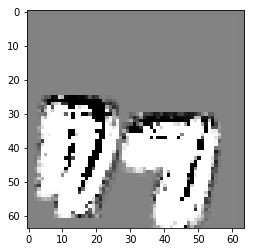

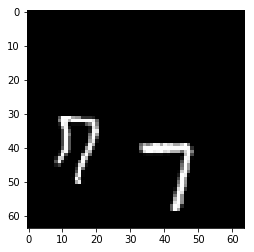

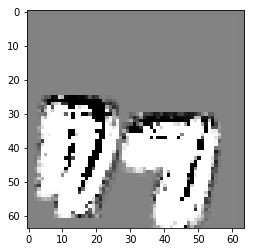

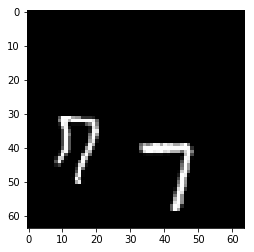

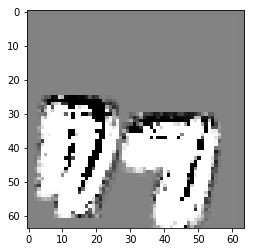

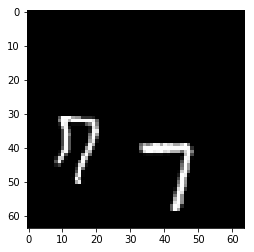

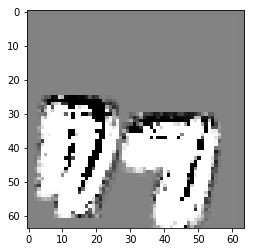

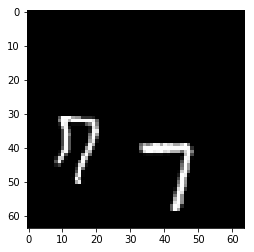

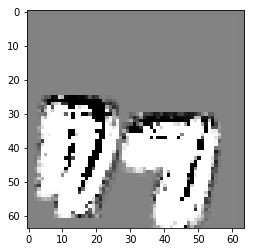

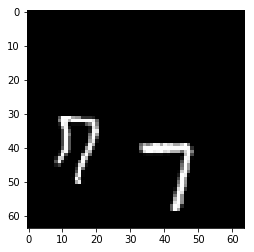

In [147]:
import matplotlib.pyplot as plt

get_ipython().magic('matplotlib inline')

for i in range(batch_size):
    pixels = predicted_frames[0,:,:,0].reshape(64,64) #images[i][10]
    plt.imshow(pixels, cmap='gray')
    plt.show()
    
    pixels = X_frames[0,:,:,0].reshape(64,64) #images[i][10]
    plt.imshow(pixels, cmap='gray')
    
    plt.show()
    